<h1> Um die Funktionalität des Nootebooks zu gewährleisten, dürfen die Codezeilen NICHT Ausgeführt werden!</h1>
<h3>Codeblöcke am besten einfach mit einem doppelklick, (weit) <b>UNTERHALB</b> des "Playbuttons", einklappen </h3>

In [74]:
# 🧩 Zelle 1: Alle Importe
import psycopg2
import configparser
import holidays
import os
import dis
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from mlxtend.frequent_patterns import apriori, association_rules
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


print("✅ Alle Imports geladen")

✅ Alle Imports geladen


In [2]:
# 🔌 Zelle 2: Verbindung zur PostgreSQL-Datenbank

# 🔌 Verbindung zur PostgreSQL-Datenbank über .ini-Datei im Projekt-Hauptverzeichnis
def db_connect(config_file='../../../config.ini', section='postgresql'):
    parser = configparser.ConfigParser()
    parser.read(config_file)

    if parser.has_section(section):
        db_params = {key: value for key, value in parser.items(section)}
    else:
        raise Exception(f"Sektion '{section}' nicht in '{config_file}' gefunden.")

    try:
        conn = psycopg2.connect(**db_params)
        print("✅ Verbindung zur Datenbank erfolgreich!")
        return conn
    except Exception as e:
        print("❌ Fehler bei der DB-Verbindung:", e)
        return None

# Verbindung aufbauen
conn = db_connect()


✅ Verbindung zur Datenbank erfolgreich!


In [3]:
# 📥 Zelle 3: Daten aus den DB-Tabellen in DataFrames laden
def load_table(name):
    return pd.read_sql(f'SELECT * FROM "{name}"', conn)


df_landingpage = load_table("landing_page_views")
df_user_behaviors = load_table("user_sessions")
df_what_did_user_do = load_table("user_events")
df_where_did_they_come_from = load_table("traffic_sources")
df_what_devices_used = load_table("device_usage")
df_where_new_visitors_come_from = load_table("traffic_source_chart")
df_who_was_visiting = load_table("daily_visitors_chart")

# display("df_landingpage")
# display(df_landingpage.head())
# display("df_user_behaviors")
# display(df_user_behaviors.head())
# display("df_what_did_user_d")
# display(df_what_did_user_do.head())
# display("df_where_did_they_come_from")
# display(df_where_did_they_come_from.head())
# display("df_what_devices_used.")
# display(df_what_devices_used.head())
# display("df_where_new_visitors_come_from")
# display(df_where_new_visitors_come_from.head())
# display("df_who_was_visiting")
# display(df_who_was_visiting.head())

print("✅ Dataframes erfolgreich geladen")

✅ Dataframes erfolgreich geladen


## 📊 Nutzer-Cluster-Analyse auf Basis von Device-Nutzung, Traffic-Quellen und Engagement-Metriken

### 🔍 Ziel der Analyse  
Diese Analyse zielt darauf ab, verschiedene Nutzersegmente anhand ihres Verhaltens, der genutzten Geräte und Traffic-Quellen zu identifizieren. Dabei werden Methoden wie Clustering (KMeans) und Hauptkomponentenanalyse (PCA) eingesetzt, um typische Nutzerprofile und deren Charakteristika zu extrahieren und visuell darzustellen.

---

### 🧠 Was macht der Code?  

1. **Datenaufbereitung:**  
   Es werden mehrere Datensätze zu Gerätenutzung, Nutzerverhalten, Events und Traffic-Quellen zusammengeführt und fehlende Werte mit Null aufgefüllt. Dabei wird die Verweildauer in Sekunden umgerechnet, um eine einheitliche Skala zu gewährleisten.

2. **Feature-Auswahl:**  
   Für verschiedene Aspekte des Nutzerverhaltens werden jeweils spezifische Merkmalssets definiert (z. B. Geräte-Nutzung plus Aktivität, Traffic-Quellen plus Sitzungsmetriken, Engagement-Metriken).

3. **Automatische Cluster-Anzahl:**  
   Die optimale Anzahl an Clustern wird anhand des Silhouette-Scores für KMeans automatisch ermittelt, um eine möglichst klare Trennung der Nutzersegmente zu erreichen.

4. **Clustering und PCA:**  
   Für jedes Merkmal-Set werden KMeans-Cluster gebildet und mit PCA auf zwei Dimensionen reduziert, um die Cluster visuell verständlich zu machen.

5. **Cluster-Benennung:**  
   Optional werden benutzerdefinierte Labels auf die Cluster angewendet, um die Interpretation zu erleichtern.

6. **Interpretation der Hauptkomponenten:**  
   Die wichtigsten Merkmale, die jede der zwei PCA-Dimensionen erklären, werden ausgegeben, um die Bedeutung der Achsen zu verstehen.

7. **Cluster-Zentren:**  
   Mittlere Werte der Cluster in den Originalmerkmalen werden dargestellt, um charakteristische Eigenschaften der einzelnen Nutzergruppen zu beschreiben.

---

### 📈 Interpretation der Ergebnisse  

**Cluster „Device & Verhalten“**  
- „Desktop Nutzer, hohe Aktivität“ zeichnet sich durch besonders viele Seitenaufrufe (284,5), hohe Desktop-Nutzung (162,9) und lange Verweildauer (130 Sek.) aus.  
- „Mobile Nutzer, hohe Verweildauer“ hat geringere Seitenaufrufe (90,6), nutzt überwiegend mobile Geräte (48,6) und verweilt durchschnittlich 98 Sekunden auf der Seite.

**Cluster „Quelle & Intensität“**  
- „Geringe Nutzerzahl & Traffic“) weist niedrige Nutzerzahlen (26,4) und Sitzungen auf Google und direkt (jeweils ~12 und ~10) auf.  
- „Hoher Traffic & Engagement“) zeigt deutlich mehr Nutzer (76,1), hohe Google-Traffic-Zahlen (55,8) und eine hohe Anzahl an Events (55,6).

**Cluster „Zeit & Event-Verhalten“**  
- „Kurze bis mittlere Verweildauer“) zeigt moderate Verweildauer (109 Sek.), Nutzeranzahl (28,6) und Seiten pro Sitzung (5,5).  
- „Hohe Nutzerzahl mit schnellen Aktionen“) zeichnet sich durch viele Nutzer (78,1) bei relativ kurzer Verweildauer (95 Sek.) und hoher Eventanzahl (59,4) aus.  
- „Intensive Nutzung (sehr lange Sitzungen)“) hat extrem lange Verweildauer (471 Sek.) bei geringer Nutzeranzahl (2,2).

**Cluster „Traffic“**  
- „Dominant Desktop Traffic“ mit sehr hohem Desktop-Nutzeranteil (388,4).  
- „Ausgewogener Mobile/Desktop Traffic“ zeigt vergleichbare Nutzungszahlen beider Geräte (~46,7 Mobile, 43,8 Desktop).  
- „Hoher Mobile Traffic“ dominiert von Mobilnutzung (140,6).

**Cluster „Engagement-Verhalten“**  
- „Stark engagierte Nutzer“ mit hoher Anzahl an Seitenaufrufen (252,9), langen Verweildauern (147,5 Sek.) und hoher Seiten pro Sitzung (12,6).  
- „Moderates Engagement“ mit moderaten Werten über alle Metriken (~90 Seitenaufrufe, 90 Sek. Verweildauer).

---

### ✅ Was lässt sich daraus ableiten?  

- **Mehrere klar unterscheidbare Nutzertypen:**  
  Nutzer unterscheiden sich deutlich in ihrem Gerät, Traffic-Quelle, Verweildauer und Engagement. Das Clustering trennt diese Gruppen sinnvoll.

- **Mobile vs. Desktop Nutzung:**  
  Desktop-Nutzer zeigen tendenziell mehr Seitenaufrufe und längere Sitzungen, während Mobile-Nutzer oft kürzere, aber hoch frequentierte Zugriffe haben.

- **Traffic-Quellen spiegeln Engagement:**  
  Hoher Traffic (z. B. Google) korreliert mit einer größeren Nutzerzahl und mehr Events, was auf intensivere Nutzung hinweist.

- **Extremnutzung existiert:**  
  Kleine Nutzergruppen mit sehr langen Sitzungen und intensiven Interaktionen zeigen, dass es neben den Massen-Nutzern auch sehr engagierte Einzelpersonen gibt.

- **Empfehlung für weitere Analyse:**  
  Die Clusterprofile können gezielt für personalisierte Inhalte oder Marketingkampagnen genutzt werden. Zudem sollte geprüft werden, wie sich Nutzer im Zeitverlauf zwischen Clustern bewegen.

---


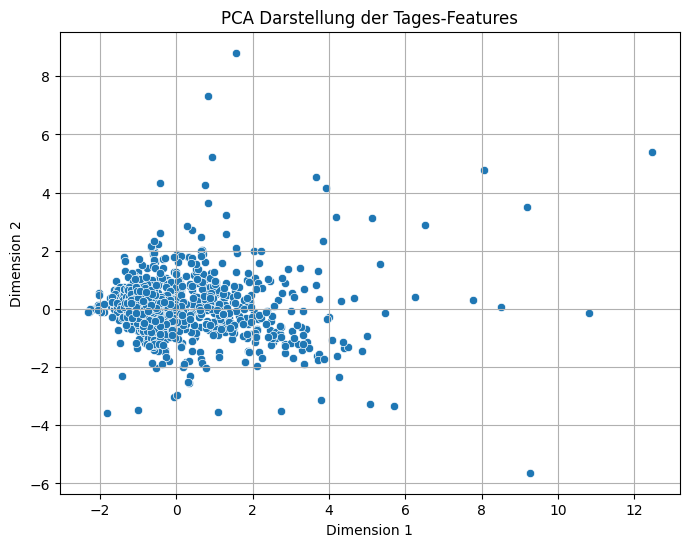

📌 **Interpretation der PCA-Dimensionen für PCA Darstellung der Tages-Features:**
- **Dimension 1** erklärt 46.2% der Gesamtvarianz und hängt stark mit: Seitenaufrufe (+), desktop (+), mobile (+)
- **Dimension 2** erklärt 19.7% der Gesamtvarianz und hängt stark mit: Durchschn. Zeit auf der Seite (+), mobile (−), ereignisanzahl (−)

------------------------------------------------------------

📌 **Interpretation der PCA-Dimensionen für** _Device-Verhalten_:
- **Dimension 1** erklärt 46.2% der Gesamtvarianz und hängt stark mit: Seitenaufrufe (+), desktop (+), mobile (+)
- **Dimension 2** erklärt 19.7% der Gesamtvarianz und hängt stark mit: Durchschn. Zeit auf der Seite (+), mobile (−), ereignisanzahl (−)

📍 **Wie die Cluster sich unterscheiden:**
- Nutzergruppe **Desktop Nutzer, hohe Aktivität** liegt bei: Dimension 1 = 2.40, Dimension 2 = -0.16
- Nutzergruppe **Mobile Nutzer, hohe Verweildauer** liegt bei: Dimension 1 = -0.60, Dimension 2 = 0.04

-----------------------------------------

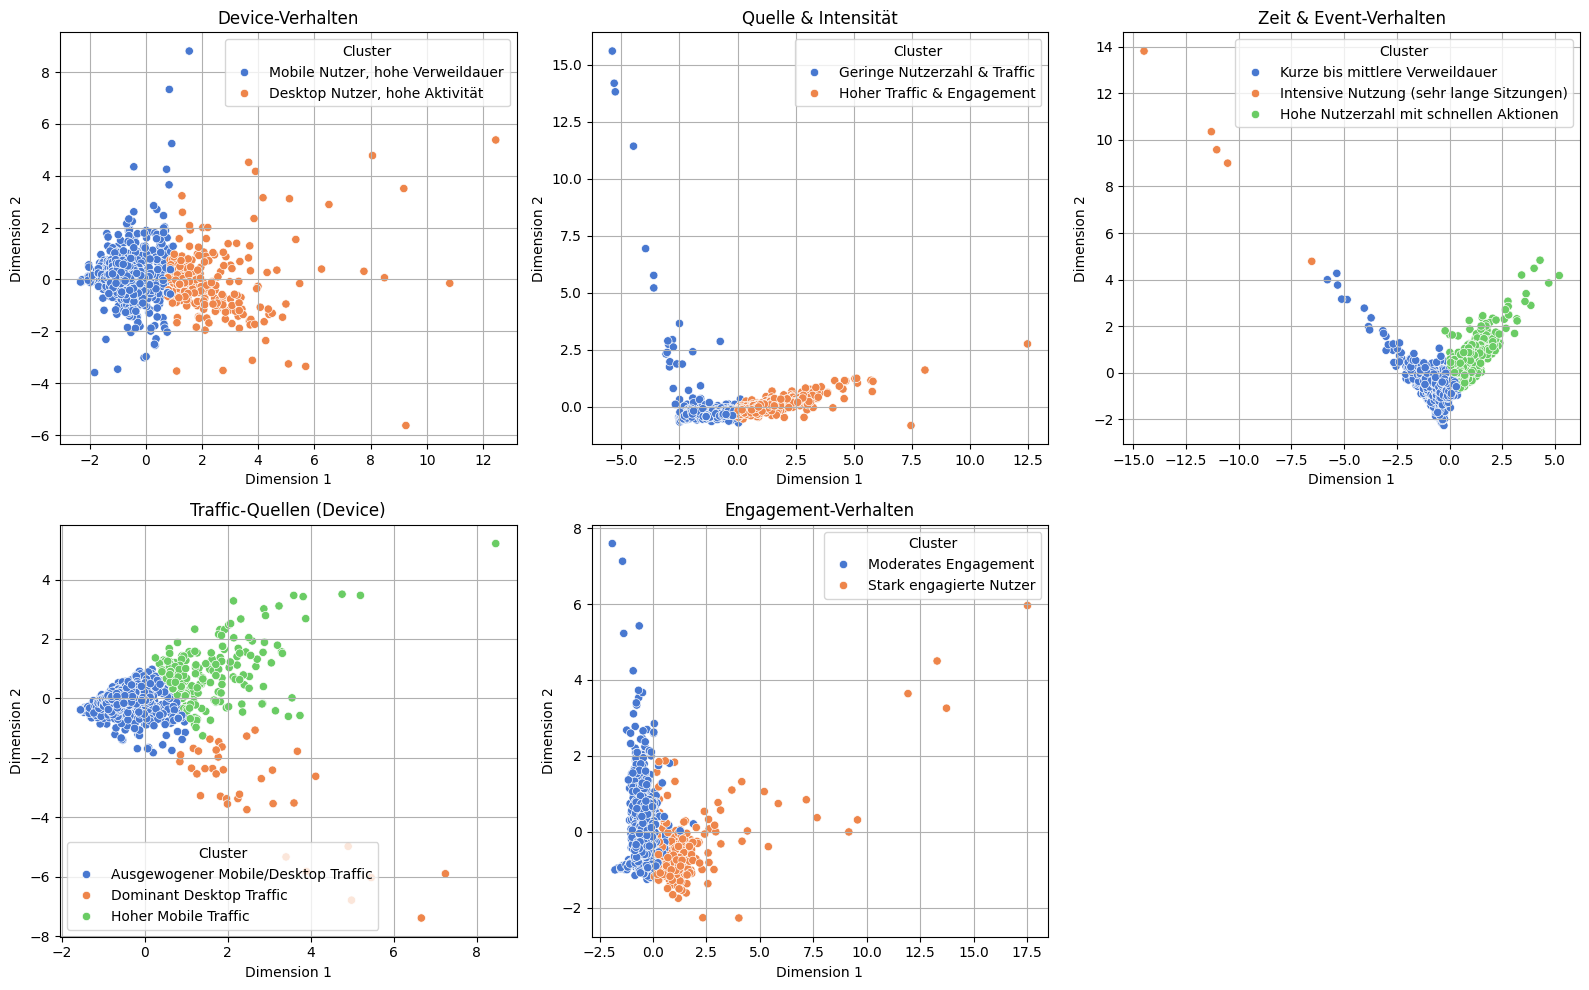

In [ ]:
### Part Eins Clustering ###

# 1. Daten vorbereiten

# Devices pivotieren
df_device_pivot = df_what_devices_used.pivot(index="datum", columns="kategorie", values="wert").reset_index()
df_device_pivot.columns.name = None

# Events aggregieren
df_events_daily = df_what_did_user_do.groupby("datum", as_index=False)["ereignisanzahl"].sum()

# Verhalten umbenennen
df_behavior_reduced = df_user_behaviors[
    ["datum", "seitenaufrufe", "durchschn._zeit_auf_der_seite", "seiten_/_sitzung", "nutzer_insgesamt"]
].rename(
    columns={
        "seitenaufrufe": "Seitenaufrufe",
        "durchschn._zeit_auf_der_seite": "Durchschn. Zeit auf der Seite",
        "seiten_/_sitzung": "Seiten / Sitzung",
        "nutzer_insgesamt": "Nutzer Insgesamt",
    }
)

# Top 3 Quellen
top3_sources = df_where_did_they_come_from.groupby("quelle")["sitzungen"].sum().sort_values(ascending=False).head(3)
df_sources_pivot = df_where_did_they_come_from[df_where_did_they_come_from["quelle"].isin(top3_sources.index)]
df_sources_pivot = df_sources_pivot.pivot(index="datum", columns="quelle", values="sitzungen").reset_index()
df_sources_pivot.columns.name = None

# Zusammenführen (ohne Gender-Daten)
data = df_device_pivot.merge(df_behavior_reduced, on="datum", how="outer")
data = data.merge(df_events_daily, on="datum", how="outer")
data = data.merge(df_sources_pivot, on="datum", how="outer")
data = data.fillna(0)

# Zeit in Sekunden
data["Durchschn. Zeit auf der Seite"] = pd.to_timedelta(
    data["Durchschn. Zeit auf der Seite"], errors="coerce"
).fillna(pd.Timedelta(seconds=0)).dt.total_seconds()

# Hilfsfunktion: beste Clusteranzahl automatisch ermitteln
def optimal_kmeans(X, max_k=6):
    best_k = 2
    best_score = -1
    for k in range(2, max_k + 1):
        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k

# Hilfsfunktion: Clustering & PCA-Plot
def cluster_and_plot_auto(data, features, pca_cols, cluster_col, cluster_label_col, title, palette, user_cluster_labels=None, ax=None):
    X = data[features].fillna(0)
    X_scaled = StandardScaler().fit_transform(X)

    n_clusters = optimal_kmeans(X_scaled)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    data[cluster_col] = kmeans.fit_predict(X_scaled)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)
    data[pca_cols[0]] = pca_result[:, 0]
    data[pca_cols[1]] = pca_result[:, 1]

    if user_cluster_labels is not None and len(user_cluster_labels) == n_clusters:
        cluster_labels = {i: user_cluster_labels[i] for i in range(n_clusters)}
    else:
        cluster_labels = {i: f"Cluster {i}" for i in range(n_clusters)}

    data[cluster_label_col] = data[cluster_col].map(cluster_labels)

    # ➕ Plot auf übergebenem ax oder eigenes plt
    if ax is None:
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    scatter = sns.scatterplot(
        x=pca_cols[0], y=pca_cols[1], hue=cluster_label_col,
        palette=palette, data=data, ax=ax, legend="full"
    )

    # 💡 Legende außerhalb des Plots anzeigen (optional)
    ax.legend(title="Cluster", loc='best')

    ax.set_title(title)
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.grid(True)

    # Optional: Erklärung im Terminal ausgeben
    print_cluster_explanation(pca, features, kmeans, cluster_labels, title)


def print_cluster_explanation(pca, features, kmeans, cluster_labels, title):
    components = pca.components_
    explained_vars = pca.explained_variance_ratio_
    print(f"📌 **Interpretation der PCA-Dimensionen für** _{title}_:")
    for i, component in enumerate(components):
        abs_weights = np.abs(component)
        top_indices = abs_weights.argsort()[-3:][::-1]
        top_features = [features[idx] for idx in top_indices]
        weights = component[top_indices]
        feature_desc = ", ".join(
            [f"{feat} ({'+' if w > 0 else '−'})" for feat, w in zip(top_features, weights)]
        )
        print(f"- **Dimension {i+1}** erklärt {explained_vars[i]:.1%} der Gesamtvarianz und hängt stark mit: {feature_desc}")
    print("\n📍 **Wie die Cluster sich unterscheiden:**")
    centers_2d = pca.transform(kmeans.cluster_centers_)
    for i, coords in enumerate(centers_2d):
        print(f"- Nutzergruppe **{cluster_labels[i]}** liegt bei: Dimension 1 = {coords[0]:.2f}, Dimension 2 = {coords[1]:.2f}")
    print("\n" + "-" * 60 + "\n")

# PCA ohne Gender-Spalten
features_pca = ["mobile", "desktop", "Seitenaufrufe", "Durchschn. Zeit auf der Seite", "ereignisanzahl"]
X = data[features_pca]
X_scaled = StandardScaler().fit_transform(X)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
data["pca1"] = pca_result[:, 0]
data["pca2"] = pca_result[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x="pca1", y="pca2", data=data)
plt.title("PCA Darstellung der Tages-Features")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.show()

components = pca.components_
explained_vars = pca.explained_variance_ratio_

print("📌 **Interpretation der PCA-Dimensionen für PCA Darstellung der Tages-Features:**")
for i, component in enumerate(components):
    abs_weights = np.abs(component)
    top_indices = abs_weights.argsort()[-3:][::-1]
    top_features = [features_pca[idx] for idx in top_indices]
    weights = component[top_indices]
    feature_desc = ", ".join(
        [f"{feat} ({'+' if w > 0 else '−'})" for feat, w in zip(top_features, weights)]
    )
    print(f"- **Dimension {i+1}** erklärt {explained_vars[i]:.1%} der Gesamtvarianz und hängt stark mit: {feature_desc}")
print("\n" + "-" * 60 + "\n")

# Angepasste benutzerdefinierte Labels
labels_gd = {
    0: "Desktop Nutzer, hohe Aktivität",
    1: "Mobile Nutzer, hohe Verweildauer"
}

labels_src = {
    0: "Geringe Nutzerzahl & Traffic",
    1: "Hoher Traffic & Engagement"
}

labels_te = {
    0: "Kurze bis mittlere Verweildauer",
    1: "Hohe Nutzerzahl mit schnellen Aktionen",
    2: "Intensive Nutzung (sehr lange Sitzungen)"
}

labels_d = {
    0: "Dominant Desktop Traffic",
    1: "Ausgewogener Mobile/Desktop Traffic",
    2: "Hoher Mobile Traffic"
}

labels_eng = {
    0: "Stark engagierte Nutzer",
    1: "Moderates Engagement"
}


fig, axes = plt.subplots(2, 3, figsize=(16, 10))  # z.B. 2 Zeilen, 3 Spalten
axes = axes.flatten()  # für einfache Iteration

cluster_and_plot_auto(
    data=data,
    features=["mobile", "desktop", "Seitenaufrufe", "Durchschn. Zeit auf der Seite", "ereignisanzahl"],
    pca_cols=["pca_gd1", "pca_gd2"],
    cluster_col="cluster_gd",
    cluster_label_col="cluster_label_gd",
    title="Device-Verhalten",
    palette="muted",
    user_cluster_labels=labels_gd,
    ax=axes[0]
)

cluster_and_plot_auto(
    data=data,
    features=list(top3_sources.index) + ["Seiten / Sitzung", "Nutzer Insgesamt", "ereignisanzahl"],
    pca_cols=["pca_src1", "pca_src2"],
    cluster_col="cluster_src",
    cluster_label_col="cluster_label_src",
    title="Quelle & Intensität",
    palette="muted",
    user_cluster_labels=labels_src,
    ax=axes[1]
)

cluster_and_plot_auto(
    data=data,
    features=["Durchschn. Zeit auf der Seite", "Seiten / Sitzung", "Nutzer Insgesamt", "ereignisanzahl"],
    pca_cols=["pca_te1", "pca_te2"],
    cluster_col="cluster_te",
    cluster_label_col="cluster_label_te",
    title="Zeit & Event-Verhalten",
    palette="muted",
    user_cluster_labels=labels_te,
    ax=axes[2]
)

cluster_and_plot_auto(
    data=data,
    features=["mobile", "desktop"],
    pca_cols=["pca_d1", "pca_d2"],
    cluster_col="cluster_d",
    cluster_label_col="cluster_label_d",
    title="Traffic-Quellen (Device)",
    palette="muted",
    user_cluster_labels=labels_d,
    ax=axes[3]
)

cluster_and_plot_auto(
    data=data,
    features=["Seitenaufrufe", "Seiten / Sitzung", "Durchschn. Zeit auf der Seite", "ereignisanzahl"],
    pca_cols=["pca_eng1", "pca_eng2"],
    cluster_col="cluster_eng",
    cluster_label_col="cluster_label_eng",
    title="Engagement-Verhalten",
    palette="muted",
    user_cluster_labels=labels_eng,
    ax=axes[4]
)

# Achse 5 (axes[5]) leer lassen, falls nur 5 Plots
axes[5].axis("off")

plt.tight_layout()
plt.show()




## 📆 Zeitliche Muster in Clusterverhalten: Wochentage & Feiertage

### 🔍 Ziel der Ergänzungsanalyse  
Aufbauend auf der zuvor durchgeführten Clusterbildung analysiert dieser Abschnitt, **wann** bestimmte Nutzertypen besonders häufig auftreten – differenziert nach **Wochentagen** und **Feiertagen**. Ziel ist es, zeitliche Nutzungsmuster in den bereits identifizierten Clustern sichtbar zu machen.

---

### 🧠 Was macht der Code?  

1. **Wochentagsanalyse pro Clustergruppe:**  
   Es werden die zuvor gebildeten Clusterlabels (z. B. aus „Device-Verhalten“ oder „Engagement-Verhalten“) gruppiert, um zu untersuchen, an welchen Wochentagen diese Nutzergruppen besonders häufig auftreten. Die Häufigkeit wird für jeden Wochentag gezählt und als Balkendiagramm visualisiert.

2. **Feiertagsanalyse pro Clustergruppe:**  
   In einem zweiten Schritt wird geprüft, ob sich bestimmte Cluster auch an Feiertagen überproportional zeigen. Dazu wird eine gefilterte Feiertags-Tabelle genutzt, die angibt, wie häufig einzelne Cluster an spezifischen Feiertagen auftreten.

3. **Visualisierung nebeneinander:**  
   Beide Analysen (Wochentag & Feiertag) werden separat für zwei Clustergruppen dargestellt. Dadurch lässt sich direkt vergleichen, welche Nutzersegmente eher werktags, am Wochenende oder an besonderen Tagen wie Feiertagen aktiv sind.

---

### 📈 Interpretation der Ergebnisse  

Die genaue inhaltliche Interpretation hängt von der konkreten Zuweisung der Clustergruppen ab (z. B. ob hier „hohes Engagement“ oder „Mobile Nutzer“ gemeint sind), aber die Analyse liefert u. a. folgende Einblicke:

- **Clusterverhalten nach Wochentagen:**  
  Es kann sichtbar werden, dass z. B. „Mobile Nutzer mit hoher Verweildauer“ besonders oft an Wochenenden aktiv sind, während „Desktop-Nutzer mit hoher Aktivität“ vermehrt an Werktagen auftreten – was auf ein arbeitsbezogenes Nutzungsverhalten hindeutet.

- **Clusterverhalten an Feiertagen:**  
  Feiertage können bestimmte Cluster signifikant beeinflussen. So könnte z. B. ein Cluster mit sehr intensiver Nutzung an Feiertagen besonders häufig erscheinen – ein Hinweis darauf, dass diese Nutzergruppe freie Tage für intensivere Nutzung verwendet.

- **Vergleich zwischen Clustergruppen:**  
  Durch die parallele Darstellung der beiden Clustergruppen in je zwei Subplots (für Wochentage und Feiertage) lässt sich erkennen, ob bestimmte Nutzertypen tendenziell „alltagsnah“ oder „freizeitnah“ agieren.

---

### ✅ Was lässt sich daraus ableiten?  

- **Zeitliche Segmentierung ist relevant:**  
  Das Nutzungsverhalten hängt nicht nur von Gerätetyp oder Engagement ab, sondern auch vom Wochentag und Kalenderkontext. Diese Dimension sollte in Analysen berücksichtigt werden.

- **Potenzial für zielgerichtete Ansprache:**  
  Erkenntnisse aus der Wochentags- und Feiertagsverteilung lassen sich in Kampagnen- oder Inhaltsstrategien überführen – etwa durch gezielte Ansprache engagierter Nutzer an Feiertagen oder beruflich geprägter Cluster an Werktagen.

- **Feiertage zeigen abweichende Nutzungsmuster:**  
  Feiertage sind keine „normalen“ Tage: einige Cluster verändern ihr Auftreten deutlich, was bei Interpretation von Zeitreihen berücksichtigt werden sollte.

- **Anschluss an weitere Analysen möglich:**  
  Eine Folgestufe könnte untersuchen, wie stark die zeitliche Verteilung einzelner Cluster mit externen Faktoren (z. B. Wetter, Werbeaktionen, Ferienzeiten) korreliert.


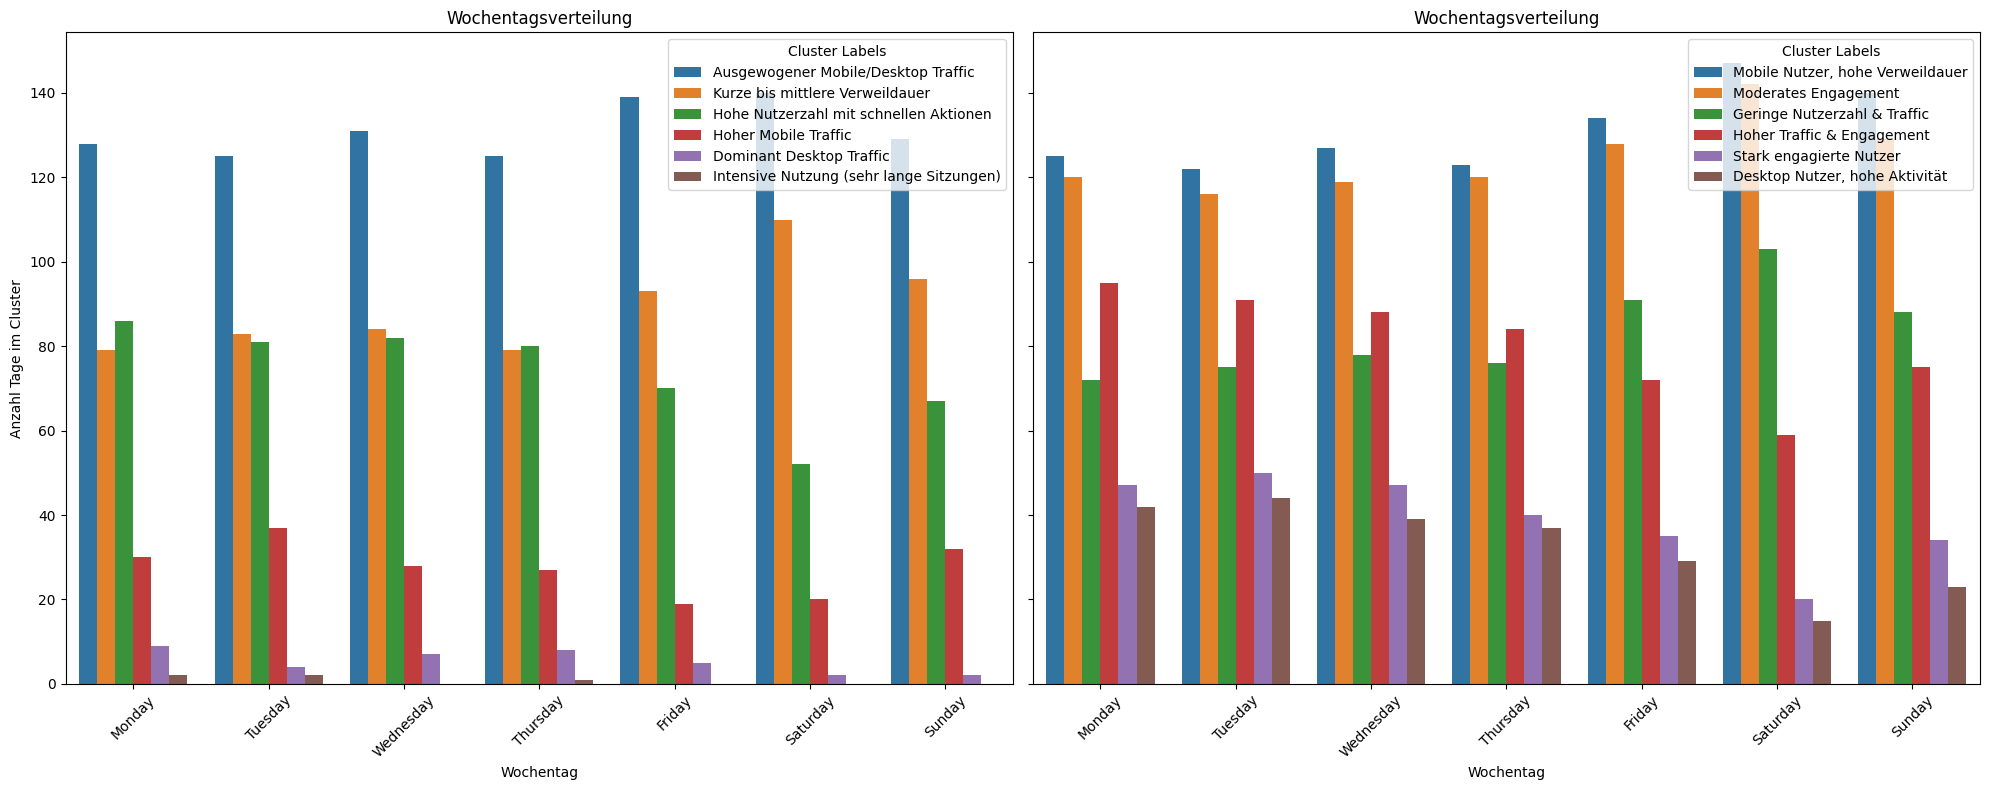


**Clusterlabels-Info**

- **„Desktop Nutzer, hohe Aktivität“**: viele Seitenaufrufe (284,5), hohe Desktop-Nutzung (162,9), lange Verweildauer (130 Sek.)

- **„Mobile Nutzer, hohe Verweildauer“**: Seitenaufrufe (90,6), überwiegend mobile Geräte (48,6), Verweildauer 98 Sek.

- **„Geringe Nutzerzahl & Traffic“**: Nutzerzahl (26,4), Sitzungen über Google/Direct (~12/~10)

- **„Hoher Traffic & Engagement“**: Nutzer (76,1), Google-Traffic (55,8), Events (55,6)

- **„Kurze bis mittlere Verweildauer“**: Verweildauer (109 Sek.), Nutzer (28,6), Seiten/Sitzung (5,5)

- **„Hohe Nutzerzahl mit schnellen Aktionen“**: Nutzer (78,1), Verweildauer (95 Sek.), Events (59,4)

- **„Intensive Nutzung“**: sehr lange Verweildauer (471 Sek.), wenige Nutzer (2,2)

- **„Dominant Desktop Traffic“**: Desktop-Anteil (388,4)

- **„Ausgewogener Mobile/Desktop Traffic“**: Mobile (46,7), Desktop (43,8)

- **„Hoher Mobile Traffic“**: Mobilnutzung (140,6)

- **„Stark engagierte Nutzer“**: Seitenaufrufe (252,9), Verweildauer (147,5 Sek.), Seiten/Sitzung (12,6)

- **„Moderates Engagement“**: ~90 Seitenaufrufe, ~90 Sek. Verweildauer



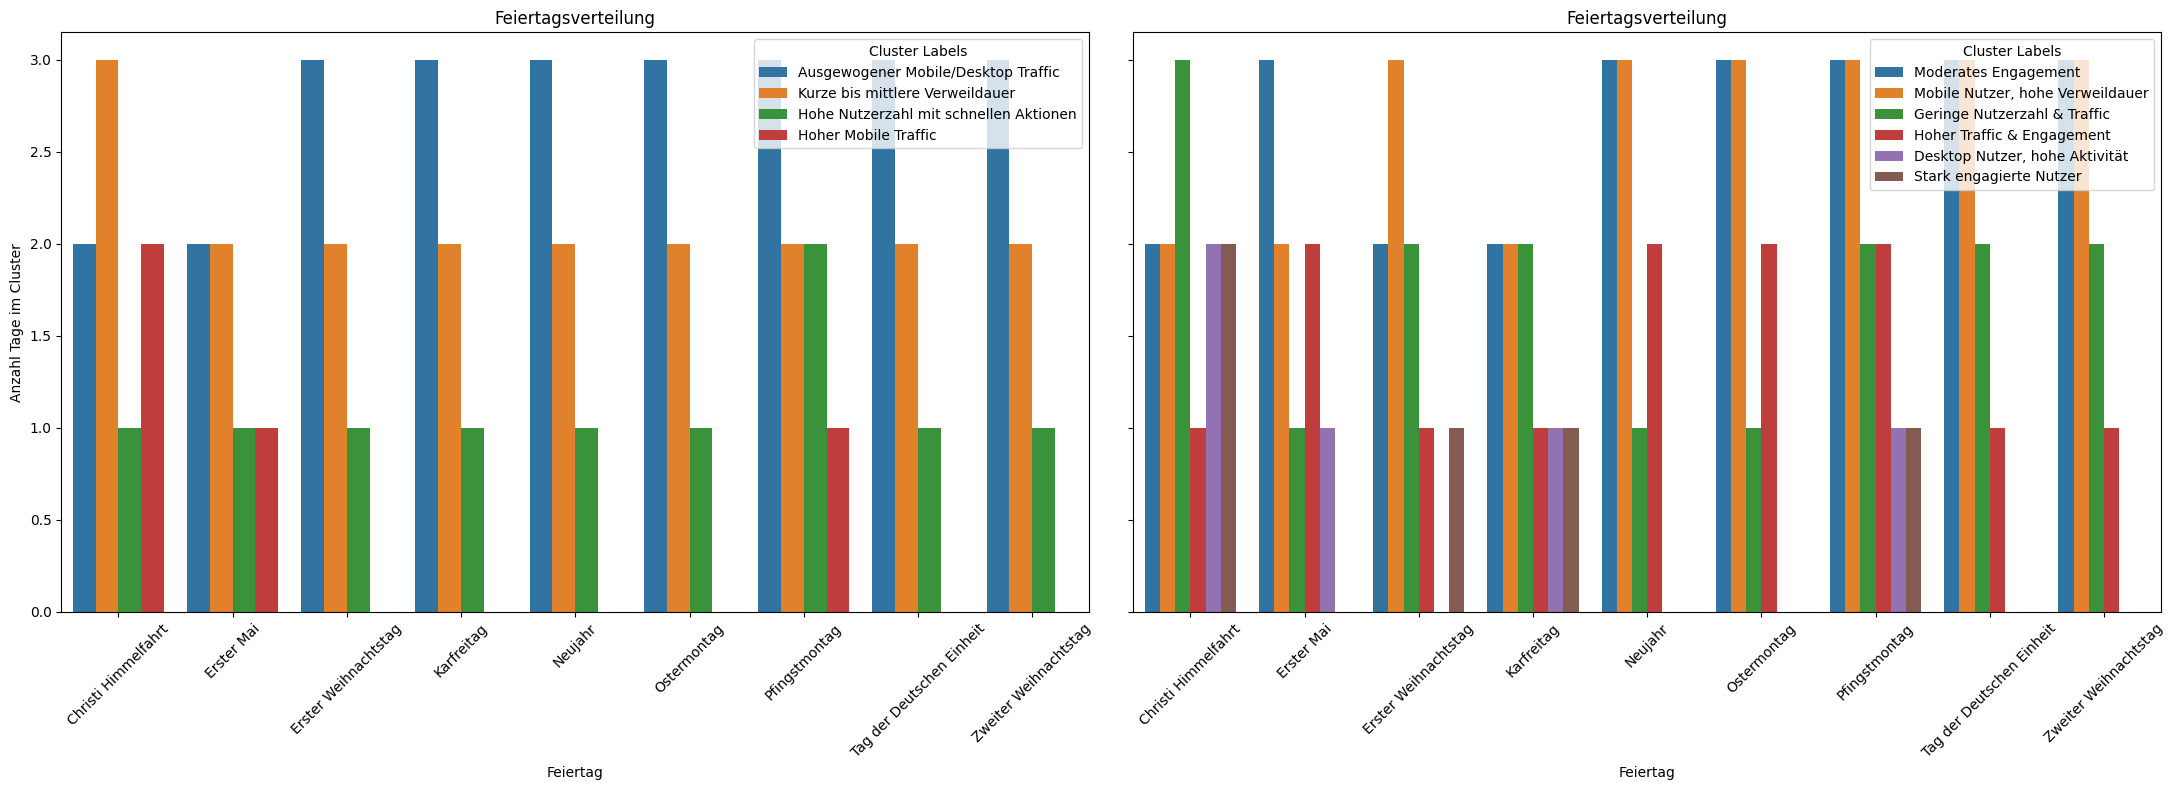

In [95]:
# -------------------- Plot-Gruppe 1: Wochentagsverteilung --------------------

# Datum konvertieren (falls noch nicht geschehen)
data['datum'] = pd.to_datetime(data['datum'])

# Wochentag und Feiertagsname berechnen
data['Wochentag'] = data['datum'].dt.day_name()
jahre = data['datum'].dt.year.unique()
de_feiertage = holidays.Germany(years=jahre)
data['Feiertag_Name'] = data['datum'].apply(lambda d: de_feiertage.get(d, "Kein Feiertag"))

# Mapping für Cols
cluster_label_cols = [
    'cluster_label_te', 
    'cluster_label_d', 
]

cluster_label_cols2 = [
    'cluster_label_src',  
    'cluster_label_eng',
    'cluster_label_gd', 
]

# supbplot
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot 1.1
dfs = []
for col in cluster_label_cols:
    temp = data.groupby(['Wochentag', col]).size().reset_index(name='Anzahl')
    temp = temp.rename(columns={col: 'Cluster_Label'})
    temp['Cluster_Typ'] = col
    dfs.append(temp)
df_all_clusters = pd.concat(dfs, ignore_index=True)
df_all_clusters['Wochentag'] = pd.Categorical(df_all_clusters['Wochentag'], categories=wochentage_reihenfolge, ordered=True)
cluster_sortierung_1 = df_all_clusters.groupby("Cluster_Label")["Anzahl"].sum().sort_values(ascending=False).index.tolist()
sns.barplot(
    data=df_all_clusters,
    x='Wochentag',
    y='Anzahl',
    hue='Cluster_Label',
    hue_order=cluster_sortierung_1,
    ci=None,
    ax=axes[0]
)
axes[0].set_title('Wochentagsverteilung')
axes[0].set_xlabel('Wochentag')
axes[0].set_ylabel('Anzahl Tage im Cluster')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Cluster Labels', loc='upper right')

# Plot 1.2
dfs = []
for col in cluster_label_cols2:
    temp = data.groupby(['Wochentag', col]).size().reset_index(name='Anzahl')
    temp = temp.rename(columns={col: 'Cluster_Label'})
    temp['Cluster_Typ'] = col
    dfs.append(temp)
df_all_clusters = pd.concat(dfs, ignore_index=True)
df_all_clusters['Wochentag'] = pd.Categorical(df_all_clusters['Wochentag'], categories=wochentage_reihenfolge, ordered=True)
cluster_sortierung_2 = df_all_clusters.groupby("Cluster_Label")["Anzahl"].sum().sort_values(ascending=False).index.tolist()
sns.barplot(
    data=df_all_clusters,
    x='Wochentag',
    y='Anzahl',
    hue='Cluster_Label',
    hue_order=cluster_sortierung_2,
    ci=None,
    ax=axes[1]
)
axes[1].set_title('Wochentagsverteilung')
axes[1].set_xlabel('Wochentag')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Cluster Labels', loc='upper right')

plt.tight_layout()
plt.show()

# -------------------- Infotext zwichen den Plots --------------------
from IPython.display import display, Markdown

cluster_info_text_md = """
**Clusterlabels-Info**

- **„Desktop Nutzer, hohe Aktivität“**: viele Seitenaufrufe (284,5), hohe Desktop-Nutzung (162,9), lange Verweildauer (130 Sek.)

- **„Mobile Nutzer, hohe Verweildauer“**: Seitenaufrufe (90,6), überwiegend mobile Geräte (48,6), Verweildauer 98 Sek.

- **„Geringe Nutzerzahl & Traffic“**: Nutzerzahl (26,4), Sitzungen über Google/Direct (~12/~10)

- **„Hoher Traffic & Engagement“**: Nutzer (76,1), Google-Traffic (55,8), Events (55,6)

- **„Kurze bis mittlere Verweildauer“**: Verweildauer (109 Sek.), Nutzer (28,6), Seiten/Sitzung (5,5)

- **„Hohe Nutzerzahl mit schnellen Aktionen“**: Nutzer (78,1), Verweildauer (95 Sek.), Events (59,4)

- **„Intensive Nutzung“**: sehr lange Verweildauer (471 Sek.), wenige Nutzer (2,2)

- **„Dominant Desktop Traffic“**: Desktop-Anteil (388,4)

- **„Ausgewogener Mobile/Desktop Traffic“**: Mobile (46,7), Desktop (43,8)

- **„Hoher Mobile Traffic“**: Mobilnutzung (140,6)

- **„Stark engagierte Nutzer“**: Seitenaufrufe (252,9), Verweildauer (147,5 Sek.), Seiten/Sitzung (12,6)

- **„Moderates Engagement“**: ~90 Seitenaufrufe, ~90 Sek. Verweildauer

"""

display(Markdown(cluster_info_text_md))



# -------------------- Plot-Gruppe 2: Feiertagsverteilung --------------------
# subpolt
fig, axes = plt.subplots(1, 2, figsize=(22, 8), sharey=True)

# Plot 2.1
dfs_feiertage = []
for col in cluster_label_cols:
    temp = data.groupby(['Feiertag_Name', col]).size().reset_index(name='Anzahl')
    temp = temp.rename(columns={col: 'Cluster_Label'})
    temp['Cluster_Typ'] = col
    dfs_feiertage.append(temp)
df_all_clusters_feiertage = pd.concat(dfs_feiertage, ignore_index=True)
df_all_clusters_feiertage_filtered = df_all_clusters_feiertage[df_all_clusters_feiertage['Feiertag_Name'] != "Kein Feiertag"].copy()
feiertag_unique = sorted(df_all_clusters_feiertage_filtered['Feiertag_Name'].unique().tolist())
df_all_clusters_feiertage_filtered['Feiertag_Name'] = pd.Categorical(
    df_all_clusters_feiertage_filtered['Feiertag_Name'],
    categories=feiertag_unique,
    ordered=True
)
cluster_sortierung_3 = df_all_clusters_feiertage_filtered.groupby("Cluster_Label")["Anzahl"].sum().sort_values(ascending=False).index.tolist()
sns.barplot(
    data=df_all_clusters_feiertage_filtered,
    x='Feiertag_Name',
    y='Anzahl',
    hue='Cluster_Label',
    hue_order=cluster_sortierung_3,
    ci=None,
    ax=axes[0]
)
axes[0].set_title('Feiertagsverteilung')
axes[0].set_xlabel('Feiertag')
axes[0].set_ylabel('Anzahl Tage im Cluster')
axes[0].tick_params(axis='x', rotation=45)
axes[0].legend(title='Cluster Labels', loc='upper right')

# Plot 2.2
dfs_feiertage = []
for col in cluster_label_cols2:
    temp = data.groupby(['Feiertag_Name', col]).size().reset_index(name='Anzahl')
    temp = temp.rename(columns={col: 'Cluster_Label'})
    temp['Cluster_Typ'] = col
    dfs_feiertage.append(temp)
df_all_clusters_feiertage = pd.concat(dfs_feiertage, ignore_index=True)
df_all_clusters_feiertage_filtered = df_all_clusters_feiertage[df_all_clusters_feiertage['Feiertag_Name'] != "Kein Feiertag"].copy()
feiertag_unique = sorted(df_all_clusters_feiertage_filtered['Feiertag_Name'].unique().tolist())
df_all_clusters_feiertage_filtered['Feiertag_Name'] = pd.Categorical(
    df_all_clusters_feiertage_filtered['Feiertag_Name'],
    categories=feiertag_unique,
    ordered=True
)
cluster_sortierung_4 = df_all_clusters_feiertage_filtered.groupby("Cluster_Label")["Anzahl"].sum().sort_values(ascending=False).index.tolist()
sns.barplot(
    data=df_all_clusters_feiertage_filtered,
    x='Feiertag_Name',
    y='Anzahl',
    hue='Cluster_Label',
    hue_order=cluster_sortierung_4,
    ci=None,
    ax=axes[1]
)
axes[1].set_title('Feiertagsverteilung')
axes[1].set_xlabel('Feiertag')
axes[1].tick_params(axis='x', rotation=45)
axes[1].legend(title='Cluster Labels', loc='upper right')

plt.tight_layout()
plt.show()


<h2>📊 Analyse der Besucherquellen mit Clustering</h2>

<p>Wir haben die wichtigsten Kennzahlen für verschiedene Besucherquellen zusammengefasst:</p>
<ul>
  <li><strong>Sitzungen:</strong> Anzahl der Besuche</li>
  <li><strong>Aufrufe:</strong> Seitenaufrufe insgesamt</li>
  <li><strong>Aufrufe pro Sitzung:</strong> Durchschnittliche Seitenaufrufe je Besuch</li>
</ul>

<h3>🔎 Schritt 1 &amp; 2: Quellen gruppieren</h3>
<p>Die Top 3 Quellen werden einzeln betrachtet, alle anderen bündeln wir in "Andere". So behalten wir den Überblick, ohne dass seltene Quellen die Analyse verzerren.</p>

<h3>🔍 Schritt 3: Clustering</h3>
<p>Wir haben die Quellen basierend auf Sitzungen, Aufrufen und Aufrufen pro Sitzung in 3 Cluster eingeteilt, um typische Besucherquellen-Gruppen zu erkennen:</p>
<ul>
  <li><strong>Cluster 0:</strong> Kleiner Traffic, moderates Engagement</li>
  <li><strong>Cluster 1:</strong> Großer Traffic, geringes Engagement</li>
  <li><strong>Cluster 2:</strong> Mittlerer Traffic, hohes Engagement</li>
</ul>

<h3>📈 Interpretation der Cluster</h3>
<ul>
  <li><strong>Großer Traffic, geringes Engagement (Cluster 1):</strong> Quellen mit vielen Sitzungen, aber eher wenigen Seitenaufrufen pro Besuch (z.B. "google").</li>
  <li><strong>Mittlerer Traffic, hohes Engagement (Cluster 2):</strong> Quellen mit weniger Besuchen als Cluster 1, aber viel mehr Seitenaufrufen pro Sitzung (z.B. "direct").</li>
  <li><strong>Kleiner Traffic, moderates Engagement (Cluster 0):</strong> Quellen mit wenig Traffic und moderaten Seitenaufrufen pro Sitzung (z.B. "Andere", "kompetenznetz-einsamkeit.de").</li>
</ul>

<h3>💡 Fazit</h3>
<p>Diese Clustering-Analyse hilft, die Besucherquellen besser zu verstehen und gezielt Prioritäten zu setzen:</p>
<ul>
  <li><em>Große Traffic-Quellen</em> wie "google" brauchen Maßnahmen, um das Engagement zu erhöhen.</li>
  <li><em>Direktzugriffe</em> sind sehr engagiert, hier lohnt sich eine Pflege der Inhalte.</li>
  <li><em>Andere Quellen</em> sollten weiter beobachtet werden, da sie zwar kleiner sind, aber dennoch wertvolles Engagement liefern können.</li>
</ul>


In [ ]:
# # Metriken berechnen "old"
# df_ts = (
#     df_where_did_they_come_from.groupby("quelle")
#     .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
#     .reset_index()
# )
#
# # Schritt 2: Nur Top 4 Quellen einzeln zeigen – Rest zu "Andere" zusammenfassen
# top_n = 3
# top_quellen = df_ts.sort_values("sitzungen", ascending=False).head(top_n)["quelle"]
# df_ts["quelle_gruppe"] = df_ts["quelle"].where(
#     df_ts["quelle"].isin(top_quellen), "Andere"
# )
#
# # Aggregation nach Quelle-Gruppe
# df_ts_agg = (
#     df_ts.groupby("quelle_gruppe")
#     .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
#     .reset_index()
# )
#
# # Schritt 3: Clustering
# scaler = StandardScaler()
# X = scaler.fit_transform(df_ts_agg[["sitzungen", "aufrufe", "aufrufe_pro_sitzung"]])
# kmeans = KMeans(n_clusters=3, random_state=42)
# df_ts_agg["cluster"] = kmeans.fit_predict(X)
#
#
# # Schritt 4: Cluster-Labels definieren (basierend auf deiner Interpretation)
# def cluster_label(cluster):
#     if cluster == 0:
#         return "Kleiner Traffic, moderates Engagement"
#     elif cluster == 1:
#         return "Großer Traffic, geringes Engagement"
#     else:
#         return "Mittlerer Traffic, hohes Engagement"
#
#
# df_ts_agg["cluster_label"] = df_ts_agg["cluster"].apply(cluster_label)
#
# # cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
# # cluster_summary = pd.DataFrame(cluster_centers, columns=['sitzungen', 'aufrufe', 'aufrufe_pro_sitzung'])
# # display("Cluster Zentren")
# # display(cluster_summary)
#
# # Schritt 5: Plot
# plt.figure(figsize=(8, 6))
# sns.scatterplot(
#     data=df_ts_agg,
#     x="sitzungen",
#     y="aufrufe_pro_sitzung",
#     size="aufrufe",
#     hue="cluster_label",
#     sizes=(100, 300),
#     palette="Set2",
#     legend="full",
# )
# for _, row in df_ts_agg.iterrows():
#     plt.text(
#         row["sitzungen"],
#         row["aufrufe_pro_sitzung"],
#         row["quelle_gruppe"],
#         fontsize=9,
#         ha="center",
#         va="center",
#     )
#
# plt.title("Traffic‑Quellen (Top 3 + Andere, Clustered)")
# plt.xlabel("Sitzungen")
# plt.ylabel("Aufrufe pro Sitzung")
# plt.legend(title="Cluster")
# plt.tight_layout()
# plt.show()

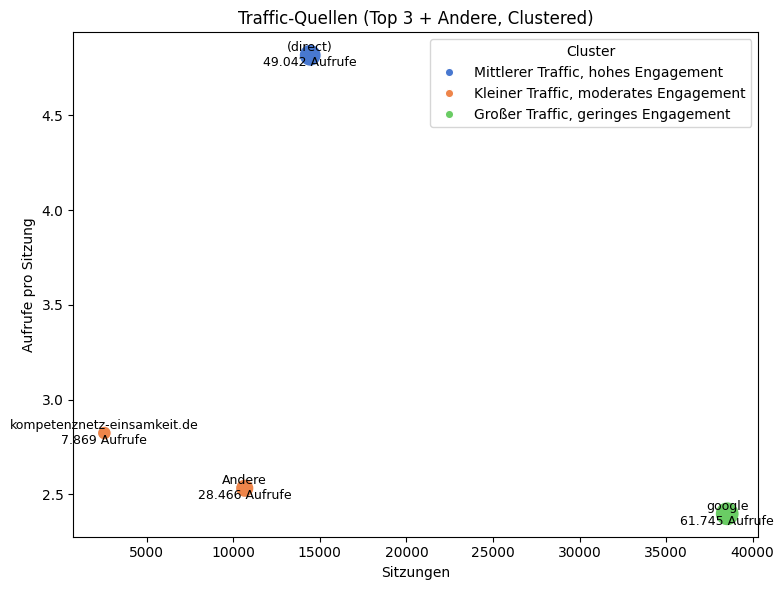

In [11]:
# Metriken berechnen
df_ts = (
    df_where_did_they_come_from.groupby("quelle")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 2: Nur Top 4 Quellen einzeln zeigen – Rest zu "Andere" zusammenfassen
top_n = 3
top_quellen = df_ts.sort_values("sitzungen", ascending=False).head(top_n)["quelle"]
df_ts["quelle_gruppe"] = df_ts["quelle"].where(
    df_ts["quelle"].isin(top_quellen), "Andere"
)

# Aggregation nach Quelle-Gruppe
df_ts_agg = (
    df_ts.groupby("quelle_gruppe")
    .agg({"sitzungen": "sum", "aufrufe": "sum", "aufrufe_pro_sitzung": "mean"})
    .reset_index()
)

# Schritt 3: Clustering
scaler = StandardScaler()
X = scaler.fit_transform(df_ts_agg[["sitzungen", "aufrufe", "aufrufe_pro_sitzung"]])
kmeans = KMeans(n_clusters=3, random_state=42)
df_ts_agg["cluster"] = kmeans.fit_predict(X)


# Schritt 4: Cluster-Labels definieren (basierend auf deiner Interpretation)
def cluster_label(cluster):
    if cluster == 0:
        return "Kleiner Traffic, moderates Engagement"
    elif cluster == 1:
        return "Großer Traffic, geringes Engagement"
    else:
        return "Mittlerer Traffic, hohes Engagement"


df_ts_agg["cluster_label"] = df_ts_agg["cluster"].apply(cluster_label)

# cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
# cluster_summary = pd.DataFrame(cluster_centers, columns=['sitzungen', 'aufrufe', 'aufrufe_pro_sitzung'])
# display("Cluster Zentren")
# display(cluster_summary)

# Schritt 5: Plot
plt.figure(figsize=(8, 6))
scatter = sns.scatterplot(
    data=df_ts_agg,
    x="sitzungen",
    y="aufrufe_pro_sitzung",
    size="aufrufe",
    hue="cluster_label",
    sizes=(100, 300),
    palette="muted",
    legend="brief",  # nur Hue-Legende erzeugen, Size-Legende nicht
)

# Textbeschriftung der Punkte
for _, row in df_ts_agg.iterrows():
    plt.text(
        row["sitzungen"],
        row["aufrufe_pro_sitzung"],
        f"{row['quelle_gruppe']}\n{int(row['aufrufe']):,} Aufrufe".replace(",", "."),
        fontsize=9,
        ha="center",
        va="center",
    )

plt.title("Traffic‑Quellen (Top 3 + Andere, Clustered)")
plt.xlabel("Sitzungen")
plt.ylabel("Aufrufe pro Sitzung")

# Nun holen wir die Handles und Labels der Hue-Legende vom Plot
handles, labels = scatter.get_legend_handles_labels()

# Die Legende von scatter.get_legend_handles_labels() enthält:
# - zuerst Einträge für size (Blasengröße)
# - danach Einträge für hue (Cluster)
# Wir müssen also die size-Einträge herausfiltern.

# Cluster-Labels sind die, die in df_ts_agg["cluster_label"] vorkommen:
cluster_labels = df_ts_agg["cluster_label"].unique()

# Filtere Handles und Labels, die zu cluster_labels passen
filtered = [(h, l) for h, l in zip(handles, labels) if l in cluster_labels]

if filtered:
    filtered_handles, filtered_labels = zip(*filtered)
    plt.legend(
        filtered_handles,
        filtered_labels,
        title="Cluster",
    )
else:
    # Fallback: keine Legende anzeigen
    plt.legend().remove()

plt.tight_layout()
plt.show()

## 📊 Absprungrate & Verweildauer je Landingpage und Trafficquelle

### 🔍 Ziel der Analyse
Diese Auswertung zeigt, wie gut einzelne Landingpages in Kombination mit verschiedenen Trafficquellen (z. B. Google, Direktzugriffe, Referral-Seiten) performen – gemessen an:
- **Gesamtaufrufen**
- **durchschnittlicher Verweildauer (in Sekunden)**
- **durchschnittlicher Absprungrate (in %)**

Damit lassen sich die effektivsten Einstiegsseiten und -quellen erkennen, um gezielt den **Website-Traffic** und das **Nutzerengagement** zu steigern.

---

### 🧠 Was macht der Code?

1. **Vorbereitung:**  
   Alle relevanten Tabellen (`df_landingpage`, `df_user_behaviors`, `df_where_did_they_come_from`) werden über das Datum verbunden.

2. **Verknüpfung der Daten:**  
   - Zuerst werden die **Landingpageaufrufe** mit Nutzungsmetriken wie Verweildauer und Absprungrate kombiniert.
   - Danach wird die **Trafficquelle** ergänzt, um zu erkennen, woher die Nutzer:innen kamen.

3. **Gruppierung:**  
   Es wird gruppiert nach:
   - `seitentitel` (Name der Landingpage)
   - `quelle` (z. B. Google, (direct), Partnerseiten etc.)

4. **Aggregation:**  
   Für jede Kombination wird berechnet:
   - `gesamtaufrufe`: Summe der Seitenaufrufe
   - `ø_zeit_sekunden`: durchschnittliche Verweildauer
   - `ø_absprungrate_%`: durchschnittliche Absprungrate

---

### 📈 Interpretation der Ergebnisse

Die Tabelle zeigt z. B.:

| Seitentitel                                       | Quelle                        | Aufrufe | Ø Zeit (Sek.) | Ø Absprungrate (%) |
|---------------------------------------------------|-------------------------------|---------|---------------|--------------------|
| Ich brauche Redezeit. | Google                      | 32.310  | 97,5          | 27,7                 |
| Ich brauche Redezeit. | (direct)                    | 32.310  | 97,5          | 27,7                 |
| ...                                                 | ...                           | ...     | ...           | ...                |

**Auffällig:**
- Die Seite „Ich brauche Redezeit“ generiert **extrem viele Aufrufe** über mehrere Quellen – besonders Google und Direktzugriffe.
- Die **Verweildauer liegt stabil bei ca. 97 Sekunden**, was ein gutes Engagement signalisiert.
- Die **Absprungrate bleibt unter 30 %**, was für Landingpages ein sehr positiver Wert ist.

Am Ende der Tabelle erscheinen Seiten mit **0 Aufrufen**, was meist durch technische Gründe oder irrelevante Inhalte erklärt werden kann.

---

### ✅ Was lässt sich daraus ableiten?

- **Top-performing Inhalte identifizieren:**  
  Die Seite „Ich brauche Redezeit“ ist sowohl bei organischer als auch direkter Quelle **hochgradig relevant** – sie sollte zentrales Element in SEO, Werbung und Startseite sein.

- **Quellenbewertung möglich:**  
  Wenn bestimmte Seiten **nur über einzelne Quellen** erfolgreich sind, kann man gezielt z. B. Google Ads verstärken oder Kooperationen mit verlinkenden Seiten ausbauen.

- **Niedrige Absprungraten** deuten auf einen funktionierenden ersten Eindruck hin – diese Seiten sind gut optimiert.

- **Handlungsbedarf bei Seiten mit 0 Aufrufen oder hoher Absprungrate:**  
  Diese Seiten sollten hinsichtlich Sichtbarkeit, Relevanz oder technischer Funktion geprüft werden.

---


In [6]:
# Absprungrate + Verweildauer je Landingpage + Trafficquelle

# Sicherstellen, dass alle Datumsangaben im gleichen Format vorliegen
df_landingpage["datum"] = pd.to_datetime(df_landingpage["datum"])
df_user_behaviors["datum"] = pd.to_datetime(df_user_behaviors["datum"])
df_where_did_they_come_from["datum"] = pd.to_datetime(
    df_where_did_they_come_from["datum"]
)

# Schritt 1: Verknüpfe Landingpage-Daten mit Nutzungsverhalten
landing_behavior = pd.merge(df_landingpage, df_user_behaviors, on="datum", how="left")

# Schritt 2: Verknüpfe zusätzlich die Trafficquelle
landing_behavior_source = pd.merge(
    landing_behavior,
    df_where_did_they_come_from[["datum", "quelle", "aufrufe"]],
    on="datum",
    how="left",
)

# Schritt 3: Gruppiere nach Seitentitel und Quelle
landing_summary = (
    landing_behavior_source.groupby(["seitentitel", "quelle"])
    .agg(
        {
            "aufrufe_x": "sum",  # aus df_landingpage
            "zeit_in_sekunden": "mean",  # aus df_user_behaviors
            "absprungrate_in_prozent": "mean",  # aus df_user_behaviors
        }
    )
    .rename(
        columns={
            "aufrufe_x": "gesamtaufrufe",
            "zeit_in_sekunden": "ø_zeit_sekunden",
            "absprungrate_in_prozent": "ø_absprungrate_%",
        }
    )
    .reset_index()
    .sort_values(by="gesamtaufrufe", ascending=False)
)

# display("Absprungrate + Verweildauer je Landingpage + Trafficquelle")
# display(landing_summary)


# Ergebnis anzeigen

# Dein DataFrame
df = landing_summary  # oder was du analysieren willst
# Entfernt alles ab dem | (inklusive)
landing_summary["seitentitel"] = landing_summary["seitentitel"].str.replace(r"\|.*$", "", regex=True).str.strip()

# Zeige die ersten 20 Zeilen sauber formatiert an
display(landing_summary.head(20))


,seitentitel,quelle,gesamtaufrufe,ø_zeit_sekunden,ø_absprungrate_%
5482,Ich brauche Redezeit.,google,32310,97.536680,27.684003
5361,Ich brauche Redezeit.,(direct),32310,97.536680,27.684003
5523,Ich brauche Redezeit.,kompetenznetz-einsamkeit.de,28488,97.227474,27.451492
14674,Willkommen,google,23284,97.536680,27.684003
14553,Willkommen,(direct),23284,97.536680,27.684003
14715,Willkommen,kompetenznetz-einsamkeit.de,21072,97.227474,27.451492
5393,Ich brauche Redezeit.,bing,16023,97.403263,30.043916
5539,Ich brauche Redezeit.,linkedin.com,13822,95.848580,28.195142
14585,Willkommen,bing,12351,97.403263,30.043916
5438,Ich brauche Redezeit.,ecosia.org,11576,94.690391,28.786584


## 📱 Geräteanalyse und Eventverhalten

### 🔍 Ziel der Analyse
Diese Analyse verknüpft die Nutzung verschiedener Gerätetypen mit dem Nutzungsverhalten in Form von ausgelösten Events. Ziel ist es, **die Anzahl der Nutzer je Gerätetyp** mit der **Anzahl der generierten Events** zu vergleichen und daraus das durchschnittliche Engagement pro Nutzer zu ermitteln.

---

### 🧠 Was macht der Code?

1. **Datumskonvertierung:**  
   Die Datumsfelder beider Datensätze (`df_what_devices_used` und `df_what_did_user_do`) werden in das `datetime`-Format überführt, um eine konsistente Zeitbasis sicherzustellen.

2. **Aggregation der Events:**  
   Die Anzahl der Events wird pro Tag summiert, um die tägliche Aktivität abzubilden.

3. **Datenzusammenführung:**  
   Die aggregierten Event-Daten werden mit den Geräte-Nutzungsdaten pro Tag zusammengeführt, damit für jeden Tag sowohl Nutzerzahlen als auch Events verfügbar sind.

4. **Gruppierung nach Gerätekategorie:**  
   Es wird die Summe der Nutzer (`gesamt_nutzer`) und der Events (`gesamt_events`) je Gerätekategorie berechnet.

5. **Berechnung der Engagement-Rate:**  
   Die durchschnittliche Anzahl der Events pro Nutzer (`events_pro_nutzer`) wird für jede Gerätekategorie berechnet.

---

### 📈 Interpretation der Ergebnisse

| Kategorie | Gesamt-Nutzer | Gesamt-Events | Events pro Nutzer |
|-----------|---------------|---------------|-------------------|
| Desktop   | 74.594        | 33.525        | 0,45              |
| Mobile    | 71.715        | 33.525        | 0,47              |
| Smart TV  | 7             | 133           | 19,00             |
| Tablet    | 2.057         | 23.462        | 11,41             |

- **Desktop und Mobile** zeigen eine ähnliche Nutzerzahl und Gesamtzahl der Events, mit vergleichsweise niedrigem durchschnittlichen Engagement (~0,45 Events pro Nutzer).
- **Tablet und Smart TV** weisen zwar deutlich weniger Nutzer auf, jedoch ein sehr hohes durchschnittliches Engagement (über 11 bzw. 19 Events pro Nutzer), was auf intensivere Nutzung schließen lässt.
- Die geringe Nutzerzahl bei Smart TV (nur 7 Nutzer) schränkt die Aussagekraft der sehr hohen Engagement-Rate deutlich ein und sollte mit Vorsicht interpretiert werden.

---

### ✅ Was lässt sich daraus ableiten?

- **Nutzerverhalten variiert stark je Gerätetyp:**  
  Desktop und Mobile werden von vielen genutzt, zeigen jedoch nur moderates Engagement. Tablets und Smart TVs werden seltener verwendet, dafür aber intensiver.

- **Vorsicht bei kleinen Stichproben:**  
  Besonders bei Smart TVs kann eine sehr geringe Nutzerbasis zu verzerrten Ergebnissen führen.

- **Handlungsempfehlung:**  
  Weitere Analysen sollten prüfen, warum Tablets und Smart TVs ein höheres Engagement aufweisen, ob dies durch spezifische Inhalte oder Nutzungsanlässe bedingt ist, und ob das Nutzererlebnis auf Desktop/Mobile verbessert werden kann.

---


In [14]:
# Geräteanalyse + Eventverhalten

# Schritt 1: Stelle sicher, dass die Datumsfelder im richtigen Format sind
df_what_devices_used["datum"] = pd.to_datetime(df_what_devices_used["datum"])
df_what_did_user_do["datum"] = pd.to_datetime(df_what_did_user_do["datum"])

# Schritt 2: Aggregiere Events pro Tag (optional: nach Gerätetyp differenzieren)
events_pro_tag = (
    df_what_did_user_do.groupby("datum").agg({"ereignisanzahl": "sum"}).reset_index()
)

# Schritt 3: Merge: Geräteanzahl + Ereignisse pro Tag
geräte_und_events = pd.merge(
    df_what_devices_used, events_pro_tag, on="datum", how="left"
)

# Schritt 4: Gruppierung nach Gerätekategorie
geräte_summary = (
    geräte_und_events.groupby("kategorie")
    .agg(
        {
            "wert": "sum",  # Geräte-Nutzer insgesamt
            "ereignisanzahl": "sum",  # Gesamtanzahl ausgelöster Events
        }
    )
    .rename(columns={"wert": "gesamt_nutzer", "ereignisanzahl": "gesamt_events"})
    .reset_index()
)

# Schritt 5: Engagement-Rate (Events pro Nutzer) berechnen
geräte_summary["events_pro_nutzer"] = (
    geräte_summary["gesamt_events"] / geräte_summary["gesamt_nutzer"]
)

# Ausgabe
display(geräte_summary)

,kategorie,gesamt_nutzer,gesamt_events,events_pro_nutzer
0,desktop,74594,33525.0,0.449433
1,mobile,71715,33525.0,0.467475
2,smart tv,7,133.0,19.000000
3,tablet,2057,23462.0,11.405931


## 🔄 Event-Funnel-Auswertung

### 🔍 Ziel der Analyse
Diese Analyse untersucht das **Verhalten der Nutzer auf der Webseite** anhand getrackter Interaktionen (Events). Sie bildet einen vereinfachten Conversion-Funnel ab – also eine Abfolge von Aktionen, die idealerweise zu einer Kontaktaufnahme führen. Ziel ist es zu erkennen, **welche Interaktionen wie häufig genutzt werden**, und wo ggf. **Absprünge oder Schwächen** im Nutzerfluss liegen.

---

### 🧠 Was macht der Code?

1. **Datumskorrektur:**  
   Das Datumsformat der Ereignisse wird vereinheitlicht.

2. **Event-Gruppierung:**  
   Alle Events werden nach ihrem Namen (`name_des_events`) gruppiert.

3. **Summierung:**  
   - `aktive_nutzer_gesamt`: Anzahl unterschiedlicher Nutzer, die das Event ausgelöst haben.
   - `ereignisse_gesamt`: Wie oft das Event insgesamt ausgelöst wurde.

4. **Sortierung:**  
   Die Events werden nach Anzahl aktiver Nutzer absteigend sortiert, um die wichtigsten Interaktionen sichtbar zu machen.

---

### 📈 Interpretation der Ergebnisse

| Eventname  | Aktive Nutzer (gesamt) | Ereignisse (gesamt) |
|------------|-------------------------------|----------------------|
| Checked    | 12.828                        | 20.383               |
| Website    | 7.329                         | 8.005                |
| Email      | 2.961                         | 3.602                |
| Phone      | 1.137                         | 1.434                |
| Image      | 88                            | 101                  |

**Beobachtungen:**
- **„Checked“** ist mit Abstand das häufigste Event – vermutlich ausgelöst durch das Öffnen oder Auswählen von Themen (z. B. Interessen- oder Themenbuttons).
- **„Website“, „Email“ und „Phone“** sind vermutlich Kontaktwege – diese Events lassen sich als konkrete Conversion-Schritte interpretieren.
- **„Image“** ist kaum relevant und wird selten genutzt.

---

### ✅ Was lässt sich daraus ableiten?

- **Starke Initialinteraktion:**  
  Die Nutzer zeigen hohes Interesse beim „Durchklicken“ – das ist ein positives Zeichen für Relevanz und Usability der Einstiegselemente.

- **Konversion messbar:**  
  Der Rückgang von „Checked“ (12.828 Nutzer) zu „Email“ (2.961) oder „Phone“ (1.137) ist typisch – zeigt aber auch, dass viele den letzten Schritt **nicht gehen**. Gründe könnten Unsicherheit, fehlendes Vertrauen oder ein zu weiter Weg zur Kontaktaufnahme sein.

- **Optimierungspotenziale:**
  - CTA-Buttons prominenter platzieren oder besser beschriften („Jetzt anonym Kontakt aufnehmen“).
  - Direkt nach „Checked“-Aktionen gezielte Call-to-Action-Einblendungen testen.
  - Vertrauen aufbauen durch Testimonials oder klare Information zur Kontaktaufnahme (z. B. Datenschutz, Anonymität).

---


In [25]:
# Event-Funnel-Auswertung

# Schritt 1: Stelle sicher, dass das Datum im richtigen Format vorliegt
df_what_did_user_do["datum"] = pd.to_datetime(df_what_did_user_do["datum"])

# Schritt 2: Gruppiere nach dem Eventnamen
event_funnel = (
    df_what_did_user_do.groupby("name_des_events")
    .agg({"aktive_nutzer": "sum", "ereignisanzahl": "sum"})
    .rename(
        columns={
            "aktive_nutzer": "aktive_nutzer_gesamt",
            "ereignisanzahl": "ereignisse_gesamt",
        }
    )
    .reset_index()
    .sort_values(by="aktive_nutzer_gesamt", ascending=False)
)

# Schritt 3: Ausgabe
display(event_funnel)

,name_des_events,aktive_nutzer_gesamt,ereignisse_gesamt
0,Checked,12828,20383
4,Website,7329,8005
1,Email,2961,3602
3,Phone,1137,1434
2,Image,88,101


## 🧠 Nutzerverhalten verstehen mit dem Apriori-Algorithmus

Der Apriori-Algorithmus hilft uns herauszufinden, welche **Nutzeraktionen auf der Website häufig gemeinsam auftreten** – quasi: „Wenn jemand X macht, macht er/sie meist auch Y.“  
Wir schauen uns das für **alle Nutzer**, sowie getrennt nach **Device** (mobile vs. desktop) und **Gender** (female vs. male) an. Wobei hier beim **Gender** wieder darauf zu achten ist das es aufrund zuweniger Daten die Ergebnise verzerren kann.

---

### 🧍‍♂️ Allgemein – Regeln für alle Nutzer

Die **häufigste Kombi** war:
- Wer **E-Mail, Checked und Website** nutzt, greift **mit hoher Wahrscheinlichkeit auch zum Telefon**.
- Umgekehrt: Wer **Phone** nutzt, hatte meistens auch **Email, Checked und Website** genutzt.

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 91.7 %       | 1.09       |
| Email + Checked + Website → Phone    | 62.0 %       | 1.09       |

👉 Diese Kombinationen sind **leicht überdurchschnittlich stark verknüpft**, aber nicht spektakulär. Klassische „Kontakt-Aktivitätscluster“.

---

### 📱 Mobile Nutzer

Hier sind dieselben Aktionen **deutlich stärker miteinander verbunden**:

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 90.4 %       | 1.99       |
| Website + Phone → Email + Checked    | 91.6 %       | 1.99       |

✅ **Lift fast 2** bedeutet: Diese Kombination kommt **fast doppelt so oft vor wie zufällig erwartet**. Das heißt: **Mobile Nutzer verhalten sich sehr konsistent**, wenn sie interagieren.

---

### 💻 Desktop Nutzer

Auch hier starke Verbindungen – sogar **noch stärker als bei Mobile!**

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 86.4 %       | **2.20**   |
| Website + Phone → Email + Checked    | 87.5 %       | **2.20**   |

💡 Interpretation: Desktop-Nutzer **interagieren seltener, aber wenn sie es tun, dann richtig gebündelt**.

---

### 👩 Weibliche Nutzer

| Aktionen (Wenn...)                    | Dann auch... | Lift |
|--------------------------------------|--------------|------------|
| Phone → Email + Checked + Website    | 92.2 %       | 1.53       |
| Website + Phone → Email + Checked    | 92.2 %       | 1.53       |

🧷 **Konsistentes Verhalten** – Ähnlich wie mobile Nutzer, aber weniger „krass“ als Desktop-User.

---

### 👨 Männliche Nutzer

Jetzt wird’s spannend:

| Aktionen (Wenn...)                     | Dann auch...       | Lift   |
|---------------------------------------|---------------------|------------|
| Checked + Phone → Email               | 97.1 %              | **5.54**   |
| Email + Website → Checked + Phone     | 56.4 %              | **5.59**   |
| Email → Checked + Website + Phone     | 55.9 %              | **5.54**   |

🔥 **Lift über 5!** → Das ist **extrem stark verknüpftes Verhalten**. Männer, die etwas tun, **machen fast alles auf einmal**. Diese Regeln sind besonders wertvoll für zielgerichtete UX-Verbesserung oder Kampagnen.

---

### 🧩 Fazit: Was sagen uns diese Regeln?

- **Kombinierte Interaktionen sind typisch**: Nutzer machen selten nur eine Sache – **Interaktionen bündeln sich** oft.
- **Desktop-Nutzer** und **männliche Besucher** zeigen **die stärkste Verknüpfung von Aktionen**.
- Erkenntnisse wie diese helfen, **Trigger für bestimmte Interaktionen zu finden** und gezielter Inhalte oder Call-to-Actions zu platzieren.

---



In [38]:
# Apriori Algorithmus


def apriori_analysis(mode="all", min_supp=0.05):

    # 1. Pivot Events nach Datum

    event_pivot = df_what_did_user_do.pivot_table(
        index="datum",
        columns="name_des_events",
        values="aktive_nutzer",
        aggfunc="sum",
        fill_value=0,
    )

    if mode == "all":

        # Binarisieren

        event_binary = event_pivot.applymap(lambda x: 1 if x > 0 else 0)

        freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)

        if freq_items.empty:

            print("⚠️ Keine häufigen Event-Kombinationen für alle Nutzer gefunden.")
            return

        rules = association_rules(freq_items, metric="lift", min_threshold=1.0)

        label = "Alle Nutzer"

    elif mode == "device":

        # Pivot Devices

        devices_pivot = df_what_devices_used.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",
            fill_value=0,
        )

        devices_share = devices_pivot.div(devices_pivot.sum(axis=1), axis=0).fillna(0)

        # Events gewichtet nach Device

        results = {}

        for device in ["mobile", "desktop"]:

            events_device = event_pivot.multiply(
                devices_share.get(device, 0), axis=0
            ).fillna(0)

            event_binary = events_device.round().applymap(lambda x: 1 if x > 0 else 0)

            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)

            if freq_items.empty:
                print(
                    f"⚠️ Keine häufigen Event-Kombinationen für {device} Nutzer*innen gefunden."
                )
                continue

            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)

            print(f"\nAssoziationsregeln für {device} Nutzer:")

            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(10)
            )
        return

    elif mode == "gender":

        # Pivot Gender

        gender_pivot = df_who_was_visiting.pivot_table(
            index="datum",
            columns="kategorie",
            values="wert",
            aggfunc="sum",
            fill_value=0,
        )

        gender_share = gender_pivot.div(gender_pivot.sum(axis=1), axis=0).fillna(0)

        # Events gewichtet nach Gender

        for gender in ["female", "male"]:

            events_gender = event_pivot.multiply(
                gender_share.get(gender, 0), axis=0
            ).fillna(0)

            event_binary = events_gender.round().applymap(lambda x: 1 if x > 0 else 0)

            freq_items = apriori(event_binary, min_support=min_supp, use_colnames=True)

            if freq_items.empty:
                print(
                    f"Keine häufigen Event-Kombinationen für {gender} Nutzer gefunden."
                )
                continue

            rules = association_rules(freq_items, metric="lift", min_threshold=1.0)

            print(f"\n Assoziationsregeln für {gender} Nutzer:")

            display(
                rules[["antecedents", "consequents", "support", "confidence", "lift"]]
                .sort_values(by="lift", ascending=False)
                .head(10)
            )
        return

    else:

        print("Modus nicht erkannt. Wähle 'all', 'device' oder 'gender'.")
        return

    # Ausgabe für Modus "all"

    print(f"\n Allgemeine Assoziationsregeln für {label}:")

    display(
        rules[["antecedents", "consequents", "support", "confidence", "lift"]]
        .sort_values(by="lift", ascending=False)
        .head(10)
    )


apriori_analysis("all")  # für alle Nutzer


apriori_analysis("device")  # für Mobile/Desktop


apriori_analysis("gender")  # für female/male


 Allgemeine Assoziationsregeln für Alle Nutzer:


,antecedents,consequents,support,confidence,lift
34,"(Website, Checked, Email)",(Phone),0.523585,0.620112,1.086477
47,(Phone),"(Website, Checked, Email)",0.523585,0.917355,1.086477
40,"(Website, Phone)","(Checked, Email)",0.523585,0.922438,1.084418
41,"(Checked, Email)","(Website, Phone)",0.523585,0.615527,1.084418
15,(Phone),"(Checked, Email)",0.525157,0.920110,1.081682
10,"(Checked, Email)",(Phone),0.525157,0.617375,1.081682
42,"(Checked, Phone)","(Website, Email)",0.523585,0.935393,1.064240
39,"(Website, Email)","(Checked, Phone)",0.523585,0.595707,1.064240
35,"(Website, Checked, Phone)",(Email),0.523585,0.940678,1.062649
46,(Email),"(Website, Checked, Phone)",0.523585,0.591474,1.062649



Assoziationsregeln für mobile Nutzer:


,antecedents,consequents,support,confidence,lift
49,(Phone),"(Website, Checked, Email)",0.247378,0.904153,1.989137
36,"(Website, Checked, Email)",(Phone),0.247378,0.544231,1.989137
42,"(Website, Phone)","(Checked, Email)",0.247378,0.915858,1.988124
43,"(Checked, Email)","(Website, Phone)",0.247378,0.537002,1.988124
12,"(Checked, Email)",(Phone),0.249126,0.540797,1.976587
17,(Phone),"(Checked, Email)",0.249126,0.910543,1.976587
44,"(Checked, Phone)","(Website, Email)",0.247378,0.924837,1.970229
41,"(Website, Email)","(Checked, Phone)",0.247378,0.527002,1.970229
37,"(Website, Checked, Phone)",(Email),0.247378,0.937086,1.967021
48,(Email),"(Website, Checked, Phone)",0.247378,0.519266,1.967021



Assoziationsregeln für desktop Nutzer:


,antecedents,consequents,support,confidence,lift
36,"(Website, Checked, Email)",(Phone),0.177448,0.451111,2.196047
49,(Phone),"(Website, Checked, Email)",0.177448,0.863830,2.196047
42,"(Website, Phone)","(Checked, Email)",0.177448,0.875000,2.195175
43,"(Checked, Email)","(Website, Phone)",0.177448,0.445175,2.195175
12,"(Checked, Email)",(Phone),0.177448,0.445175,2.167152
17,(Phone),"(Checked, Email)",0.177448,0.863830,2.167152
44,"(Checked, Phone)","(Website, Email)",0.177448,0.886463,2.148546
41,"(Website, Email)","(Checked, Phone)",0.177448,0.430085,2.148546
35,(Phone),"(Website, Email)",0.181818,0.885106,2.145258
30,"(Website, Email)",(Phone),0.181818,0.440678,2.145258



 Assoziationsregeln für female Nutzer:


,antecedents,consequents,support,confidence,lift
49,(Phone),"(Website, Checked, Email)",0.38724,0.922261,1.534825
36,"(Website, Checked, Email)",(Phone),0.38724,0.644444,1.534825
42,"(Website, Phone)","(Checked, Email)",0.38724,0.922261,1.527283
43,"(Checked, Email)","(Website, Phone)",0.38724,0.641278,1.527283
12,"(Checked, Email)",(Phone),0.38724,0.641278,1.527283
17,(Phone),"(Checked, Email)",0.38724,0.922261,1.527283
45,"(Email, Phone)","(Website, Checked)",0.38724,0.988636,1.517861
40,"(Website, Checked)","(Email, Phone)",0.38724,0.594533,1.517861
41,"(Website, Email)","(Checked, Phone)",0.38724,0.625899,1.517468
44,"(Checked, Phone)","(Website, Email)",0.38724,0.938849,1.517468



 Assoziationsregeln für male Nutzer:


,antecedents,consequents,support,confidence,lift
41,"(Website, Email)","(Checked, Phone)",0.097923,0.564103,5.591252
44,"(Checked, Phone)","(Website, Email)",0.097923,0.970588,5.591252
13,"(Checked, Phone)",(Email),0.097923,0.970588,5.543868
37,"(Website, Checked, Phone)",(Email),0.097923,0.970588,5.543868
48,(Email),"(Website, Checked, Phone)",0.097923,0.559322,5.543868
16,(Email),"(Checked, Phone)",0.097923,0.559322,5.543868
30,"(Website, Email)",(Phone),0.099407,0.572650,5.513797
35,(Phone),"(Website, Email)",0.099407,0.957143,5.513797
36,"(Website, Checked, Email)",(Phone),0.097923,0.568966,5.478325
49,(Phone),"(Website, Checked, Email)",0.097923,0.942857,5.478325
